## Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
# ---- Library import ----
from torch.utils.data import DataLoader


# ---- My utils ----
from models import *
from utils.data_augmentation import data_augmentation_selector
from utils.dataload import dataset_selector, MMsDataset
from utils.training import *

In [3]:
np.set_printoptions(precision=4)
data_augmentation="none"
img_size, crop_size = 224, 224

## Load Model

In [4]:
model_name = "resnet34_unet_imagenet_encoder"
model = model_selector(model_name, in_size=(crop_size, crop_size))
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))


--- Frosted pretrained backbone! ---


In [5]:
model.load_state_dict(torch.load("../checkpoints/acdc.pt"))
model.eval()
print("Model loaded correctly!")

Model loaded correctly!


## Load data

In [6]:
train_aug, train_aug_img, val_aug = data_augmentation_selector(data_augmentation, img_size, crop_size)

Using None Data Augmentation


In [7]:
batch_size = 6
data_fold = 0
normalization = "standardize"

train_dataset = MMsDataset(
    mode="train", transform=train_aug, img_transform=train_aug_img,
    fold=data_fold, normalization=normalization
)


val_dataset = MMsDataset(
    mode="validation", transform=val_aug, img_transform=[],
    fold=data_fold, normalization=normalization
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, drop_last=False)

## Evaluation

In [8]:
binary_threshold = 0.5

In [9]:
criterion="bce_dice_border_ce"
weights_criterion="0.3,0.4,0.2,0.05,0.65"
criterion, weights_criterion, multiclass_criterion = get_criterion(criterion, weights_criterion)

In [10]:
iou, dice, val_loss = val_step(
    val_loader, model, criterion, weights_criterion, multiclass_criterion, binary_threshold,
    save_preds=False, save_path="acdc_notebook_preds", swap_values=[[1,3]]
)

In [11]:
iou

array([0.7397, 0.9933, 0.6931, 0.5624, 0.71  ])

In [18]:
val_batch_iter = iter(val_loader)

In [24]:
image, original_img, original_mask, mask, img_id = next(val_batch_iter)

In [25]:
image = image.type(torch.float).cuda()
prob_pred = model(image)
for indx, single_pred in enumerate(prob_pred):
    # Calculate metrics resizing prediction to original mask shape
    pred_mask = convert_multiclass_mask(single_pred.unsqueeze(0)).data.cpu().numpy()
    pred_mask = reshape_masks(pred_mask.squeeze(0), original_mask.shape[1:3])

In [26]:
swap = np.where(pred_mask==1, 3, np.where(pred_mask==3, 1, pred_mask))

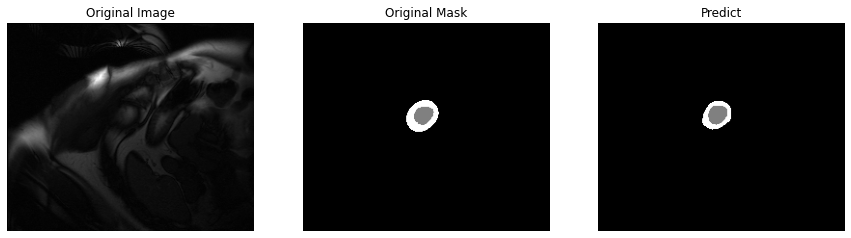

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.axis("off");ax2.axis("off");ax3.axis("off")
ax1.set_title("Original Image")
ax1.imshow(original_img.squeeze(0), cmap="gray")
ax2.set_title("Original Mask")
ax2.imshow(original_mask.squeeze(0), cmap="gray")
ax3.set_title("Predict")
ax3.imshow(swap, cmap="gray")